# **FLUXO DE MODELAGEM: ALGORITMOS DE CLASSIFICAÇÃO MULTINOMIAL**
### *Exemplo: Plano de Saúde*



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler                       # Balanceamento de classes
from sklearn.compose import make_column_selector, ColumnTransformer          # Transformação e seleção de variáveis
from sklearn.preprocessing import StandardScaler, OneHotEncoder              # Padronização de quantitativas e criação de dummies para qualitativas
from sklearn.tree import DecisionTreeClassifier                              # Árvore de decisão
from sklearn.ensemble import RandomForestClassifier                          # Floresta aleatória
from sklearn.ensemble import AdaBoostClassifier                              # AdaBoost
from sklearn.ensemble import GradientBoostingClassifier                      # Gradient boosting
from xgboost import XGBClassifier                                            # XGBoost
from lightgbm import LGBMClassifier                                          # LightGBM
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate   # Validação cruzada
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV         # Otimização de hiperparâmetros via grid search e random search
import shap                                                                  # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [ ]:
dados = pd.read_table("Plano_Saude.txt", sep = "\t")

### Verificação de tipos das variáveis da base de dados

In [ ]:
dados.dtypes

,0
ID_CLIENTE,object
NIVEL_SATISFACAO,float64
RELACAO_CUSTO_RENDA,float64
QTDE_UTILIZACOES_12M,int64
TEMPO_PLANO,float64
QTDE_SERVICOS_12M,int64
QTDE_ATRASOS_12M,int64
FLAG_MUDANCA_RESIDENCIA_12M,object
QTDE_RECLAMACOES_12M,int64
QTDE_DEPENDENTES,int64


### Alteração de tipos de variáveis, se necessário
##### Variáveis quantitativas devem ser armazenadas como **float64** (com decimais) ou **int64** (inteiras). Já variáveis qualitativas costumam ser representadas como **bool** (binárias), **object** (categóricas) ou **category** (categóricas, com otimização de memória).

In [ ]:
# dados['NOME_DA_VARIAVEL'] = dados['NOME_DA_VARIAVEL'].astype('int64')
# dados['NOME_DA_VARIAVEL'] = dados['NOME_DA_VARIAVEL'].astype('float64')
# dados['NOME_DA_VARIAVEL'] = dados['NOME_DA_VARIAVEL'].astype('bool')
# dados['NOME_DA_VARIAVEL'] = dados['NOME_DA_VARIAVEL'].astype('object')
# dados['NOME_DA_VARIAVEL'] = dados['NOME_DA_VARIAVEL'].astype('category')

### Visualização da base de dados

In [ ]:
display(dados)

,ID_CLIENTE,NIVEL_SATISFACAO,RELACAO_CUSTO_RENDA,QTDE_UTILIZACOES_12M,TEMPO_PLANO,QTDE_SERVICOS_12M,QTDE_ATRASOS_12M,FLAG_MUDANCA_RESIDENCIA_12M,QTDE_RECLAMACOES_12M,QTDE_DEPENDENTES,IDADE,STATUS
0,CLI000001,7.7,0.11,6,4.4,3,0,Nao,0,2,78,Mantem
1,CLI000002,9.8,0.49,3,3.3,1,0,Nao,0,1,21,Mantem
2,CLI000003,6.2,0.12,4,6.4,1,0,Nao,0,0,1,Up
3,CLI000004,7.4,0.35,15,5.6,1,2,Nao,3,0,10,Mantem
4,CLI000005,0.3,0.25,26,3.5,2,2,Nao,0,1,89,Up
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CLI099996,9.4,0.39,10,3.6,1,6,Nao,2,0,26,CancInvol
99996,CLI099997,9.2,0.25,3,6.3,2,0,Nao,1,0,42,Up
99997,CLI099998,9.6,0.09,5,8.0,2,2,Nao,1,0,23,Mantem
99998,CLI099999,5.2,0.43,2,5.9,1,0,Sim,0,0,33,Mantem


### Separação de features e target

In [ ]:
X = dados.drop(columns = ['STATUS', 'ID_CLIENTE']) # Remover variável target, variáveis chave ou outras variáveis meramente auxiliares
y = dados['STATUS'] # Variável target

### Codificação de target multinomial com valores numéricos
##### Tal codificação é um requisito do XGBClassifier e de alguns outros algoritmos.

In [ ]:
# Codificação com valores numéricos
mapping = {
    'CancInvol': 0,
    'CancVol': 1,
    'Down': 2,
    'Mantem': 3,
    'Up': 4
}

y = y.map(mapping)

### Cópias das features e target
##### Criação de cópias dos objetos X e y, para preservá-los em caso de redução da base de desenvolvimento do modelo

In [ ]:
X_sample = X
y_sample = y

### Balanceamento de base de dados (undersampling) e redução do tamanho da amostra, se necessário
##### Caso haja forte desbalanceamento entre as frequências das categorias da variável *target*, o balanceamento pode ajudar a proporcionar maior taxa de acerto em categorias minoritárias. Caso a base de dados seja grande mesmo após undersampling, pode-se selecionar uma sub-amostra ainda menor, para acelerar o processamento.

In [ ]:
# Contagem de valores na variável resposta antes do balanceamento/redução
y.value_counts()

,count
STATUS,
3,67000
4,13000
2,10000
0,6000
1,4000


In [ ]:
# Balanceamento de base de dados via undersampling; caso seja necessário reduzir ainda mais o tamanho da amostra, escolha os tamanhos no argumento 'sampling_strategy'
rus = RandomUnderSampler(sampling_strategy = {0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000}, random_state = 123)
X_sample, y_sample = rus.fit_resample(X_sample, y_sample)

In [ ]:
# Contagem de valores na variável resposta após o balanceamento
y_sample.value_counts()

,count
STATUS,
0,2000
1,2000
2,2000
3,2000
4,2000


### Tratamento de variáveis explicativas: padronização e criação de dummies
##### Nesta etapa, também chamada de pré-processamento, costuma-se **padronizar** as variáveis quantitativas (note que a padronização não é necessária para regressões ou modelos baseados em árvores) e **criar colunas dummies** para as variáveis qualitativas.

In [ ]:
# Pré-processamento automático, com base nos tipos das variáveis
pre_processamento = ColumnTransformer(
    transformers = [
        # ('num', StandardScaler(), make_column_selector(dtype_include = ['int64', 'float64'])),
        ('cat', OneHotEncoder(drop = 'first'), make_column_selector(dtype_include = ['object', 'category']))
    ],
    remainder = 'passthrough')

### Lista de algoritmos e hiperparâmetros testados via *grid search*
##### Execute a próxima célula apenas se quiser otimizar via *grid search*

In [ ]:
modelos = {
    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
        'min_samples_leaf': [100, 200, 500, 1000],
        'max_depth': [2, 3, 5, 10]
    }),
    'FLORESTA ALEATÓRIA': (RandomForestClassifier(n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
        'min_samples_leaf': [100, 200, 500, 100],
        'max_depth': [2, 3, 5, 10]
    }),
    'ADABOOST': (AdaBoostClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5]
    }),
    'GRADIENT BOOSTING': (GradientBoostingClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_samples_leaf': [100, 200, 500, 1000]
    }),
    'XGBOOST': (XGBClassifier(n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_child_weight': [1, 3, 5, 10],
        'gamma': [0, 0.1, 0.5, 1]
    }),
    'LIGHTGBM': (LGBMClassifier(verbose = -1, n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_data_in_leaf': [100, 200, 500, 1000]
    })
}

### Lista de algoritmos e hiperparâmetros testados via *random search*
##### Execute a próxima célula apenas se quiser otimizar via *random search*

In [ ]:
modelos = {
    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': np.arange(0, 0.11, 0.01),
        'min_samples_leaf': np.arange(100, 1001),
        'max_depth': np.arange(2, 11)
    }),
    'FLORESTA ALEATÓRIA': (RandomForestClassifier(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': np.arange(0, 0.11, 0.01),
        'min_samples_leaf': np.arange(100, 1001),
        'max_depth': np.arange(2, 11)
    }),
    'ADABOOST': (AdaBoostClassifier(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01)
    }),
    'GRADIENT BOOSTING': (GradientBoostingClassifier(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_samples_leaf': np.arange(100, 1001)
    }),
    'XGBOOST': (XGBClassifier(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_child_weight': np.arange(1, 11),
        'gamma': np.arange(0, 1.1, 0.1)
    }),
    'LIGHTGBM': (LGBMClassifier(verbose = -1, n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_data_in_leaf': np.arange(100, 1001)
    })
}

### Estimativa de desempenho por meio de validação cruzada aninhada

In [ ]:
# Aplicação do pré-processamento
X_sample_transformed = pre_processamento.fit_transform(X_sample)

In [ ]:
# Auxiliares para armazenamento do melhor modelo
melhor_algoritmo = ""
melhor_modelo = None
melhor_score = float('-inf')

In [ ]:
# Quantidade de folds nas camadas interna e externa (substitua KFold por StratifiedKFold se necessário)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [ ]:
# Avaliação de modelos por validação cruzada aninhada
for nome, (algoritmo, parametros) in modelos.items():

  # Métricas de interesse
  scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}

  # Escolha entre grid search ou random search. No random search, altere a métrica que deseja otimizar em 'refit' e a quantidade de iterações, se for necessário
  # grid_search = GridSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC_OVR', n_jobs = -1)
  random_search = RandomizedSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 50, random_state = 123, n_jobs = -1)
  nested_scores = cross_validate(random_search, X = X_sample_transformed, y = y_sample, cv = outer_cv, scoring = scoring, n_jobs = -1)

  # Verificando se o modelo atual é o melhor
  if np.mean(nested_scores['test_AUC_OVR']) > melhor_score:
      melhor_algoritmo = nome
      melhor_modelo = random_search
      melhor_score = np.mean(nested_scores['test_AUC_OVR'])

  # Resultados
  print(f'--- {nome} ---')
  print("Média de AUC-OVR: " + str(round(np.mean(nested_scores['test_AUC_OVR']), 3)))
  print("D.P. de AUC-OVR: " + str(round(np.std(nested_scores['test_AUC_OVR']), 3)))
  print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
  print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))
  print("")

print(f"O melhor algoritmo é {melhor_algoritmo}, para os valores de hiperparâmetros testados.")

--- ÁRVORE DE DECISÃO ---
Média de AUC-OVR: 0.811
D.P. de AUC-OVR: 0.007
Média de Acurácia Balanceada: 0.52
D.P. de Acurácia Balanceada: 0.01

--- FLORESTA ALEATÓRIA ---
Média de AUC-OVR: 0.865
D.P. de AUC-OVR: 0.004
Média de Acurácia Balanceada: 0.587
D.P. de Acurácia Balanceada: 0.008

--- ADABOOST ---
Média de AUC-OVR: 0.867
D.P. de AUC-OVR: 0.004
Média de Acurácia Balanceada: 0.639
D.P. de Acurácia Balanceada: 0.013

--- GRADIENT BOOSTING ---
Média de AUC-OVR: 0.905
D.P. de AUC-OVR: 0.004
Média de Acurácia Balanceada: 0.658
D.P. de Acurácia Balanceada: 0.011

--- XGBOOST ---
Média de AUC-OVR: 0.907
D.P. de AUC-OVR: 0.004
Média de Acurácia Balanceada: 0.661
D.P. de Acurácia Balanceada: 0.009

--- LIGHTGBM ---
Média de AUC-OVR: 0.905
D.P. de AUC-OVR: 0.004
Média de Acurácia Balanceada: 0.656
D.P. de Acurácia Balanceada: 0.008

O melhor algoritmo é XGBOOST, para os valores de hiperparâmetros testados.


### Ajuste de modelo final na base de desenvolvimento, usando validação cruzada



In [ ]:
# Quantidade de folds (substitua KFold por StratifiedKFold se necessário)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)

In [ ]:
# Métricas de interesse
scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}

In [ ]:
# Escolha entre grid search ou random search. No random search, altere a métrica que deseja otimizar em 'refit' e a quantidade de iterações, se for necessário
# modelo_final = GridSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'AUC_OVR')
modelo_final = RandomizedSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 50, random_state = 123, n_jobs = -1)
modelo_final.fit(X_sample_transformed, y_sample)

print(f"Melhores hiperparâmetros para {melhor_algoritmo}: {modelo_final.best_params_}")

Melhores hiperparâmetros para XGBOOST: {'n_estimators': 180, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.17, 'gamma': 0.1}


### Importância das features do modelo final

In [ ]:
# Auxiliar: nomes das features após pré-processamento
features_qualitativas = X_sample.select_dtypes(include = ['object', 'category']).columns
features_qualitativas = pre_processamento.named_transformers_['cat'].get_feature_names_out(features_qualitativas) if not features_qualitativas.empty else features_qualitativas
features_quantitativas = X_sample.select_dtypes(include = ['int64', 'float64']).columns
features = list(features_qualitativas) + list(features_quantitativas)

In [ ]:
# Cálculo de medida de importância de Gini
importancias = modelo_final.best_estimator_.feature_importances_

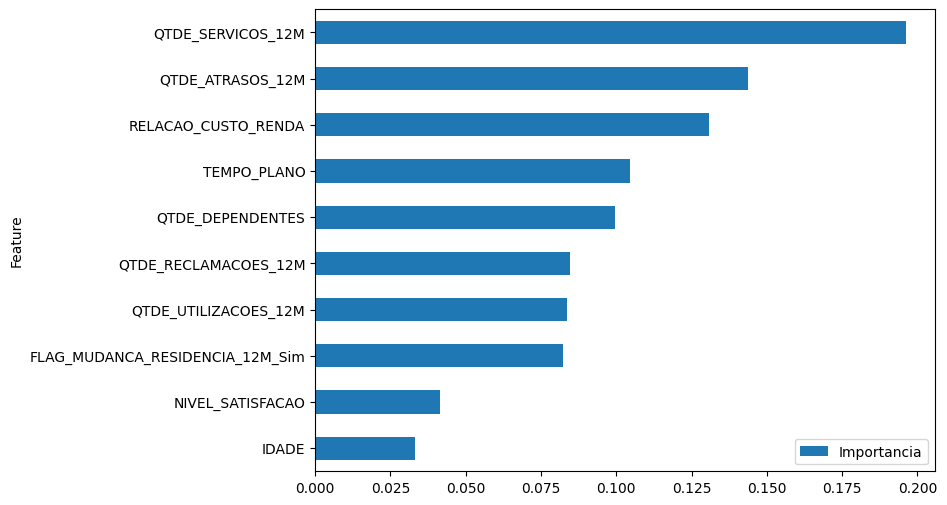

In [ ]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [ ]:
# Cálculo de valores SHAP para as observações
if melhor_algoritmo == 'ADABOOST' or melhor_algoritmo == 'GRADIENT BOOSTING':
  print("O cálculo de valores SHAP não está implementado para este algoritmo no caso multinomial, apenas binário.")
else:
  explainer = shap.Explainer(modelo_final.best_estimator_)
  valores_shap = explainer(X_sample_transformed)

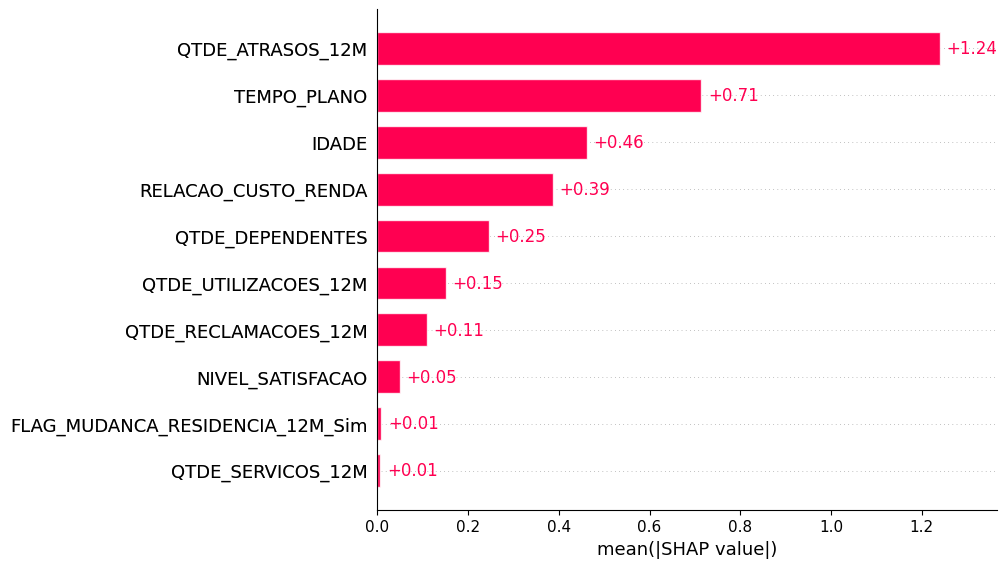

In [ ]:
# Gráfico do SHAP absoluto médio por feature; varie o índice i dentro de valores_shap[:,:,i] para cada categoria de target
if melhor_algoritmo == 'ADABOOST' or melhor_algoritmo == 'GRADIENT BOOSTING':
  print("O cálculo de valores SHAP não está implementado para este algoritmo no caso multinomial, apenas binário.")
else:
  shap.plots.bar(shap.Explanation(values = valores_shap[:,:,0], feature_names = features))

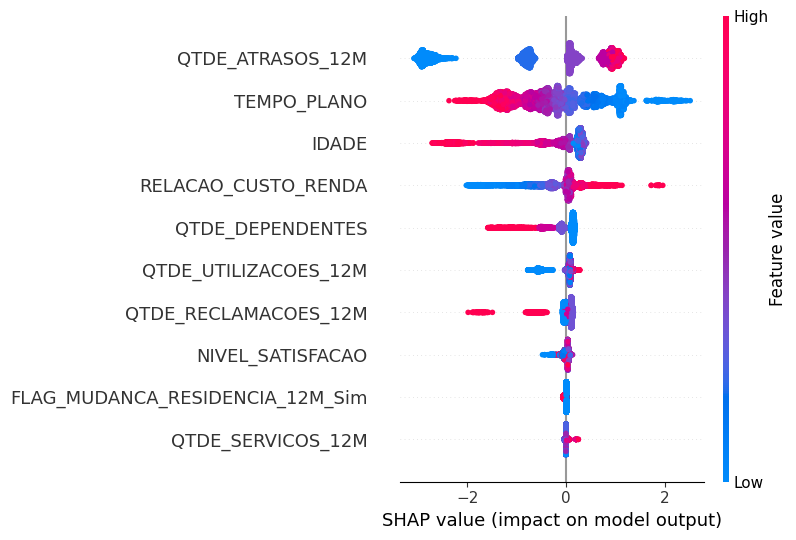

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot); varie o índice i dentro de valores_shap[:,:,i] para cada categoria de target
if melhor_algoritmo == 'ADABOOST' or melhor_algoritmo == 'GRADIENT BOOSTING':
  print("O cálculo de valores SHAP não está implementado para este algoritmo no caso multinomial, apenas binário.")
else:
  shap.summary_plot(shap.Explanation(values = valores_shap[:,:,0], feature_names = features))

### Aplicação de modelo final na base completa (caso tenha havido redução da base para a modelagem)



In [ ]:
# Aplicação do pré-processamento
X_transformed = pre_processamento.fit_transform(X)

In [ ]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = pd.DataFrame(modelo_final.best_estimator_.predict_proba(X_transformed)[:,:], columns = modelo_final.best_estimator_.classes_)
dados = pd.concat([dados, y_prob], axis = 1)

In [ ]:
# Atribuição da categoria predita
dados['y_pred'] = modelo_final.best_estimator_.predict(X_transformed)

In [ ]:
# Tabela de classificação: real vs. predito (frequências absolutas)
pd.crosstab(y, dados['y_pred'])

y_pred,0,1,2,3,4
STATUS,,,,,
0,4564,732,336,263,105
1,477,2957,346,184,36
2,754,1422,5763,1771,290
3,4192,4029,9990,33879,14910
4,377,180,251,2349,9843


In [ ]:
# Tabela de classificação: real vs. predito (frequências relativas)
pd.crosstab(y, dados['y_pred'], normalize = 'index').round(3) * 100

y_pred,0,1,2,3,4
STATUS,,,,,
0,76.1,12.2,5.6,4.4,1.8
1,11.9,73.9,8.6,4.6,0.9
2,7.5,14.2,57.6,17.7,2.9
3,6.3,6.0,14.9,50.6,22.3
4,2.9,1.4,1.9,18.1,75.7


### Aplicação de modelo final em outra base (por exemplo, para validação out of time)

In [ ]:
# Leitura da nova base de dados
novos_dados = pd.read_table("Plano_Saude.txt", sep = "\t")

In [ ]:
# Verificação de tipos das variáveis da voca base de dados
novos_dados.dtypes

,0
ID_CLIENTE,object
NIVEL_SATISFACAO,float64
RELACAO_CUSTO_RENDA,float64
QTDE_UTILIZACOES_12M,int64
TEMPO_PLANO,float64
QTDE_SERVICOS_12M,int64
QTDE_ATRASOS_12M,int64
FLAG_MUDANCA_RESIDENCIA_12M,object
QTDE_RECLAMACOES_12M,int64
QTDE_DEPENDENTES,int64


In [ ]:
# Alteração de tipos de variáveis, se necessário (devem ser realizadas as mesmas alterações aplicadas na base de desenvolvimento)
# novos_dados['NOME_DA_VARIAVEL'] = novos_dados['NOME_DA_VARIAVEL'].astype('int64')
# novos_dados['NOME_DA_VARIAVEL'] = novos_dados['NOME_DA_VARIAVEL'].astype('float64')
# novos_dados['NOME_DA_VARIAVEL'] = novos_dados['NOME_DA_VARIAVEL'].astype('bool')
# novos_dados['NOME_DA_VARIAVEL'] = novos_dados['NOME_DA_VARIAVEL'].astype('object')
# novos_dados['NOME_DA_VARIAVEL'] = novos_dados['NOME_DA_VARIAVEL'].astype('category')

In [ ]:
# Visualização da base de dados
display(novos_dados)

,ID_CLIENTE,NIVEL_SATISFACAO,RELACAO_CUSTO_RENDA,QTDE_UTILIZACOES_12M,TEMPO_PLANO,QTDE_SERVICOS_12M,QTDE_ATRASOS_12M,FLAG_MUDANCA_RESIDENCIA_12M,QTDE_RECLAMACOES_12M,QTDE_DEPENDENTES,IDADE,STATUS
0,CLI000001,7.7,0.11,6,4.4,3,0,Nao,0,2,78,Mantem
1,CLI000002,9.8,0.49,3,3.3,1,0,Nao,0,1,21,Mantem
2,CLI000003,6.2,0.12,4,6.4,1,0,Nao,0,0,1,Up
3,CLI000004,7.4,0.35,15,5.6,1,2,Nao,3,0,10,Mantem
4,CLI000005,0.3,0.25,26,3.5,2,2,Nao,0,1,89,Up
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CLI099996,9.4,0.39,10,3.6,1,6,Nao,2,0,26,CancInvol
99996,CLI099997,9.2,0.25,3,6.3,2,0,Nao,1,0,42,Up
99997,CLI099998,9.6,0.09,5,8.0,2,2,Nao,1,0,23,Mantem
99998,CLI099999,5.2,0.43,2,5.9,1,0,Sim,0,0,33,Mantem


In [ ]:
# Separação de features e target
X = novos_dados.drop(columns = ['STATUS', 'ID_CLIENTE']) # Remover variável target, variáveis chave ou outras variáveis meramente auxiliares
y = novos_dados['STATUS'] # Variável target

In [ ]:
# Aplicação do pré-processamento
X_transformed = pre_processamento.fit_transform(X)

In [ ]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = pd.DataFrame(modelo_final.best_estimator_.predict_proba(X_transformed)[:,:], columns = modelo_final.best_estimator_.classes_)
novos_dados = pd.concat([novos_dados, y_prob], axis = 1)

In [ ]:
# Atribuição da categoria predita
novos_dados['y_pred'] = modelo_final.best_estimator_.predict(X_transformed)

In [ ]:
# Tabela de classificação: real vs. predito (frequências absolutas)
pd.crosstab(y, novos_dados['y_pred'])

y_pred,0,1,2,3,4
STATUS,,,,,
CancInvol,4564,732,336,263,105
CancVol,477,2957,346,184,36
Down,754,1422,5763,1771,290
Mantem,4192,4029,9990,33879,14910
Up,377,180,251,2349,9843


In [ ]:
# Tabela de classificação: real vs. predito (frequências relativas)
pd.crosstab(y, novos_dados['y_pred'], normalize = 'index').round(3) * 100

y_pred,0,1,2,3,4
STATUS,,,,,
CancInvol,76.1,12.2,5.6,4.4,1.8
CancVol,11.9,73.9,8.6,4.6,0.9
Down,7.5,14.2,57.6,17.7,2.9
Mantem,6.3,6.0,14.9,50.6,22.3
Up,2.9,1.4,1.9,18.1,75.7
